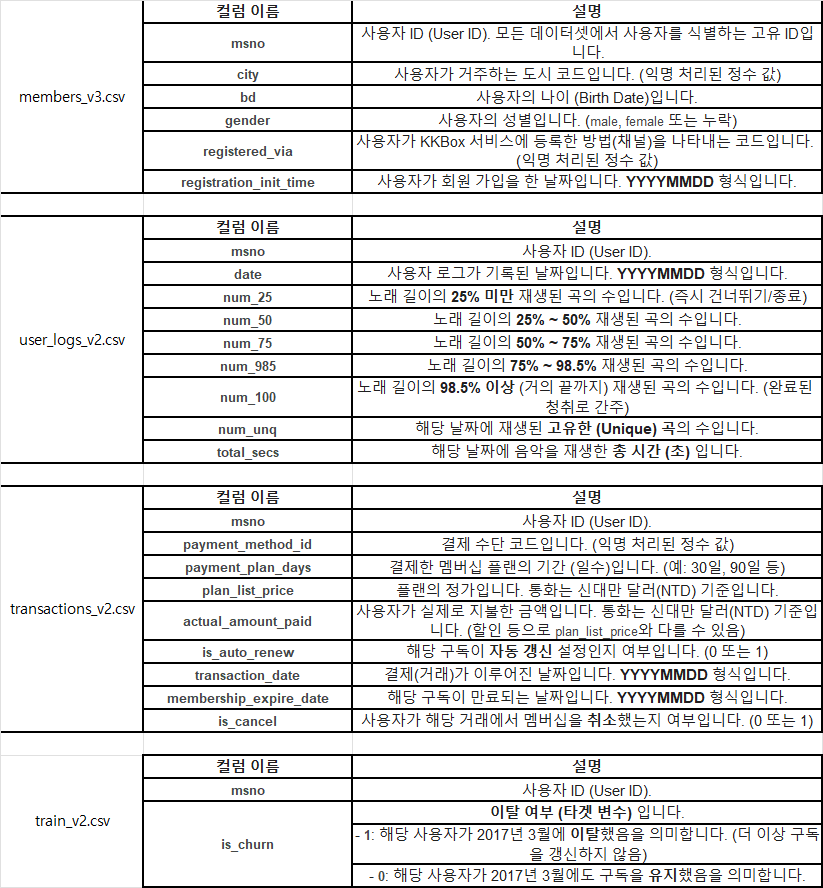

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
members = pd.read_csv('data/members_v3.csv')
train = pd.read_csv('data/train_v2.csv')
transactions = pd.read_csv('data/transactions_v2.csv')
logs = pd.read_csv('data/user_logs_v2.csv')

In [6]:
print(members.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   msno                    6769473 non-null  object
 1   city                    6769473 non-null  int64 
 2   bd                      6769473 non-null  int64 
 3   gender                  2339968 non-null  object
 4   registered_via          6769473 non-null  int64 
 5   registration_init_time  6769473 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 309.9+ MB
None


In [7]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   msno      970960 non-null  object
 1   is_churn  970960 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


In [9]:
transactions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   msno                    1431009 non-null  object
 1   payment_method_id       1431009 non-null  int64 
 2   payment_plan_days       1431009 non-null  int64 
 3   plan_list_price         1431009 non-null  int64 
 4   actual_amount_paid      1431009 non-null  int64 
 5   is_auto_renew           1431009 non-null  int64 
 6   transaction_date        1431009 non-null  int64 
 7   membership_expire_date  1431009 non-null  int64 
 8   is_cancel               1431009 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 98.3+ MB


In [11]:
logs.info(show_counts=True)
logs['msno'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18396362 entries, 0 to 18396361
Data columns (total 9 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   msno        18396362 non-null  object 
 1   date        18396362 non-null  int64  
 2   num_25      18396362 non-null  int64  
 3   num_50      18396362 non-null  int64  
 4   num_75      18396362 non-null  int64  
 5   num_985     18396362 non-null  int64  
 6   num_100     18396362 non-null  int64  
 7   num_unq     18396362 non-null  int64  
 8   total_secs  18396362 non-null  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.2+ GB


1103894

In [ ]:
logs[]

np.int64(18396362)

| 테이블          | 컬럼     | 결측처럼 볼 값 | 처리 전략    |
| ------------ | ------ | -------- | -------- |
| members      | gender | unknown  | 결측 + 플래그 |
| members      | bd     | ≤0, >100 | 결측       |
| members      | city   | 0        | 플래그      |
| transactions | 금액     | 0        | 유지       |
| transactions | 날짜     | 파싱 실패    | 결측       |
| user_logs    | 재생 수   | 0        | 유지       |
| train        | -      | -        | 없음       |


In [3]:
# 데이터의 컬럼별 결측치 있는지 확인하는 함수
def check_missing(df, name):
    print(f'[{name}]')
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    print(missing)
    print('-' * 40)

check_missing(train, 'train')
check_missing(members, 'members')
check_missing(transactions, 'transactions')
check_missing(logs, 'user_logs')


[train]
Series([], dtype: int64)
----------------------------------------
[members]
gender    4429505
dtype: int64
----------------------------------------
[transactions]
Series([], dtype: int64)
----------------------------------------
[user_logs]
Series([], dtype: int64)
----------------------------------------


In [4]:
# 결측치 비율 확인하는 함수
def check_missing_ratio(df, name):
    print(f'[{name}]')
    ratio = df.isnull().mean() * 100
    ratio = ratio[ratio > 0].sort_values(ascending=False)
    print(ratio)
    print('-' * 40)

check_missing_ratio(members, 'members')


[members]
gender    65.433528
dtype: float64
----------------------------------------


In [10]:
# 결측치 유무 다시 확인
print(members['gender'].unique())
print(members.dtypes)
print(members['gender'].value_counts(dropna=False))
print(members['bd'].value_counts().head(10))

[nan 'female' 'male']
msno                      object
city                       int64
bd                        object
gender                    object
registered_via             int64
registration_init_time     int64
dtype: object
gender
NaN       4429505
male      1195355
female    1144613
Name: count, dtype: int64
bd
22    112200
21    110574
20    110452
27    102769
23    101500
24     97252
26     92433
25     91514
19     91374
18     90659
Name: count, dtype: int64


In [11]:
# 의미 없는 값 NA로 변환 후 결측치 수 확인 ( bd = 0 / gender = nan )
members['gender'] = members['gender'].replace('unknown', pd.NA)
members['bd'] = members['bd'].replace({0: pd.NA})
check_missing(members, 'members')
members.loc[(members['bd'] <= 0) | (members['bd'] > 100), 'bd'] = pd.NA

# bd와 gender의 결측치를 무시하는게 아닌, 새로운 변수로 지정하여 프로그램의 충성도가 낮다고 평가하여 이탈율과 연관지어 계산하는 방법은 어떰?
# 거의 비슷한 수가 bd / gender를 입력하지 않았음


[members]
bd        4540215
gender    4429505
dtype: int64
----------------------------------------


In [34]:
transactions['transaction_date'] = pd.to_datetime(
    transactions['transaction_date'], format='%Y%m%d'
)

transactions['transaction_date']

0         2017-01-31
1         2015-08-09
2         2017-03-03
3         2017-03-29
4         2017-03-23
             ...    
1431004   2017-02-15
1431005   2017-03-06
1431006   2017-03-08
1431007   2017-03-18
1431008   2016-12-12
Name: transaction_date, Length: 1431009, dtype: datetime64[ns]

In [51]:
members['city'].value_counts().sort_index()

city
1     4804326
3       27282
4      246848
5      385069
6      135200
7       11610
8       45975
9       47639
10      32482
11      47489
12      66843
13     320978
14      89940
15     190213
16       5092
17      27772
18      38039
19       1199
20       4233
21      30837
22     210407
Name: count, dtype: int64

### 플래그 데이터

| 컬럼           | 플래그 이름         | 의미         |
| ------------ | -------------- | ---------- |
| gender       | gender_missing | 성별 미입력     |
| bd           | bd_invalid     | 나이 비정상     |
| registration | reg_early      | 오래된 유저 여부  |


In [ ]:
# gender를 설정하지 않은 데이터를 새로운 컬럼으로 정의 ( 1: 데이터 입력 안함 / 0: 데이터 입력함 )
members['gender_missing'] = members['gender'].isna().astype(int)
members['gender_missing'].value_counts()

gender_missing
1    4429505
0    2339968
Name: count, dtype: int64

In [64]:
# 16년 이전에 가입한 사람 수 / 오래된 유저
members['registration_init_time'] = pd.to_datetime(
    members['registration_init_time'], format='%Y%m%d'
)

members['reg_early'] = (
    members['registration_init_time'] < '2016-01-01'
).astype(int)

members['bd_invalid'] = (
    (members['bd'].isna()) |
    (members['bd'] <= 0) |
    (members['bd'] > 100)
).astype(int)

members['reg_early'].value_counts()

reg_early
1    4041028
0    2728445
Name: count, dtype: int64

In [67]:
members.columns

Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'city_is_0', 'gender_missing', 'reg_early',
       'bd_invalid'],
      dtype='object')

In [68]:
df = train.merge(members, on='msno', how='left')

In [61]:
df['city_is_0'].isna().sum()
members['city'].isna().sum()

np.int64(0)

In [69]:
flag_cols = [
    'gender_missing',
    'bd_invalid',
    'city_is_0',
    'reg_early'
]

for col in flag_cols:
    print(f'\n[{col}]')
    display(
        df.groupby(col)['is_churn']
        .agg(['mean', 'count'])
        .rename(columns={'mean': 'churn_rate'})
    )



[gender_missing]


,churn_rate,count
gender_missing,,
0.0,0.129430,388905
1.0,0.065907,472062



[bd_invalid]


,churn_rate,count
bd_invalid,,
0.0,0.132718,386715
1.0,0.063519,474252



[city_is_0]


,churn_rate,count
city_is_0,,
0.0,0.094601,860967



[reg_early]


,churn_rate,count
reg_early,,
0.0,0.092389,228414
1.0,0.095399,632553


In [77]:
df['city_is_0'].value_counts(dropna=False)
members.info() # 6769473
train.info() # 6769473

print(6769473-5908506)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 10 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   city                    int64         
 2   bd                      object        
 3   gender                  object        
 4   registered_via          int64         
 5   registration_init_time  datetime64[ns]
 6   city_is_0               int64         
 7   gender_missing          int64         
 8   reg_early               int64         
 9   bd_invalid              int64         
dtypes: datetime64[ns](1), int64(6), object(3)
memory usage: 516.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   msno      970960 non-null  object
 1   is_churn  970960 non-null  int64 
dtypes: int64(1), obje

In [ ]:
print(members['msno'].is_unique)
print(train['msno'].is_unique)


True
True


In [80]:
# members에만 있고 train에는 없는 유저
members_only = set(members['msno']) - set(train['msno'])
len(members_only)

5908506

In [79]:
# train에만 있고 members에는 없는 유저
train_only = set(train['msno']) - set(members['msno'])
len(train_only)


109993

In [ ]:
# 겹치는 유저 수 확인 (교집합)
common_users = set(train['msno']) & set(members['msno'])
len(common_users)


860967

In [ ]:

print(f"members only: {len(members_only)}")
print(f"train only: {len(train_only)}")
print(f"common users: {len(common_users)}")


members only: 5908506
train only: 109993
common users: 860967


In [ ]:
# 실제 NaN 유저가 train_only와 일치하는지 검증 (확인용)
nan_users = set(
    df.loc[df['city'].isna(), 'msno']
)

len(nan_users & train_only) / len(nan_users)


"""
본 프로젝트에서는 단순 결측치가 아닌,
회원 메타데이터 자체가 존재하지 않는 사용자 집단이
이탈 행동에서 유의미한 차이를 보임을 확인했다.
"""

1.0

gender_missing
| 여부 | churn_rate |
| -- | ---------- |
| 0  | 0.129      |
| 1  | **0.066**  |

bd_invalid
| 여부 | churn_rate |
| -- | ---------- |
| 0  | 0.133      |
| 1  | **0.064**  |

→ 회원 정보가 없는 유저가 오히려 이탈률이 낮음

### 1. “결측 자체”를 하나의 feature로 고정
→ has_member_profile = 0 / 1

### 2. city / gender / bd는 절대 복원하지 않음
→ 그대로 NaN 유지
- (트리 계열 모델은 NaN 자체를 분기 신호로 사용)

### 3. 모델링 관점 근거
| 모델                  | NaN 처리          |
| ------------------- | --------------- |
| LightGBM            | NaN 분기 가능       |
| XGBoost             | 가능              |
| CatBoost            | 매우 강함           |
| Logistic Regression | ❌ 불가 (별도 처리 필요) |

본 데이터에서 확인된 결측치는 단순한 데이터 누락이 아니라,

회원 프로필이 존재하지 않는 사용자 집단을 의미하는 구조적 신호였다.

해당 집단은 일반 회원 대비 유의미하게 낮은 이탈률을 보였으며,

본 프로젝트에서는 이를 삭제·대체하지 않고

결측 여부 자체를 중요한 feature로 활용하였다.